In [2]:
%matplotlib inline
import xarray as xr
import matplotlib.pyplot as plt
import os
import numpy as np
from matplotlib import colors
import matplotlib
import cartopy.crs as ccrs
import matplotlib.patches as mpatches
import pandas as pd
import re
from scipy import interpolate
import cmocean

In [3]:
import cartopy
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature, RIVERS
import seaborn as sns
from shapely.geometry import LinearRing, MultiPoint, MultiPolygon
from shapely.geometry.point import Point
import shapely.geometry as geometry
from shapely.ops import cascaded_union, polygonize
from scipy.spatial import Delaunay
from descartes import PolygonPatch

In [4]:
scale = '50m'

plt.rcParams.update({'mathtext.default':  'regular' })

class Rasm(ccrs.Projection):

    def __init__(self):

        proj4_params = {'R': 6371200.0,
                        'lat_0': 90.0,
                        'lat_1': 90,
                        'lat_2': 90,
                        'lon_0': -114.0+360,
                        'proj': 'lcc',
                        'units': 'm',
                        'x_0': 9469302.950316086,
                        'y_0': 6201952.603370549}

        super(Rasm, self).__init__(proj4_params)

    @property
    def boundary(self):
        coords = ((self.x_limits[0], self.y_limits[0]),(self.x_limits[1], self.y_limits[0]),
                  (self.x_limits[1], self.y_limits[1]),(self.x_limits[0], self.y_limits[1]),
                  (self.x_limits[0], self.y_limits[0]))

        return ccrs.sgeom.Polygon(coords).exterior

    @property
    def threshold(self):
        return 100000.0

    @property
    def x_limits(self):
        return (0, 16423961.103252266)

    @property
    def y_limits(self):
        return (0, 12228062.194885937)

directories for all runs

In [5]:
direc_def_monthly = '/u/home/gergel/agu_runs/default_run/monthly'
direc_def_daily = '/u/home/gergel/agu_runs/default_run/daily'
direc_pert_monthly = '/u/home/gergel/agu_runs/perturbed_run/sl_deeper/monthly'
direc_pert_daily = '/u/home/gergel/agu_runs/perturbed_run/sl_deeper/daily'

In [6]:
# daily files 
filename1 = 'fluxes_daily.1989-09-01.nc'
filename2 = 'fluxes_daily.1994-09-01.nc'
filename3 = 'fluxes_daily.1999-09-01.nc'
filename4 = 'fluxes_daily.2004-09-01.nc'
filename5 = 'fluxes_daily.2009-09-01.nc'
filename6 = 'fluxes_daily.2014-09-01.nc'

In [7]:
# load files 
file1 = xr.open_dataset(os.path.join(direc_def_daily, filename1))
file2 = xr.open_dataset(os.path.join(direc_def_daily, filename2))
file3 = xr.open_dataset(os.path.join(direc_def_daily, filename3))
file4 = xr.open_dataset(os.path.join(direc_def_daily, filename4))
file5 = xr.open_dataset(os.path.join(direc_def_daily, filename5))
file6 = xr.open_dataset(os.path.join(direc_def_daily, filename6))
# splice file6 
file6_mod = file6.loc[dict(time=slice('2014-09-01', '2016-08-31'))]

In [8]:
# concat daily default run files 
monthly_mean_soilnodetemp_file1 = file1.OUT_SOIL_TNODE.resample(freq = 'm', dim = 'time', how = 'mean')
monthly_mean_soilnodetemp_file2 = file2.OUT_SOIL_TNODE.resample(freq = 'm', dim = 'time', how = 'mean')
monthly_mean_soilnodetemp_file3 = file3.OUT_SOIL_TNODE.resample(freq = 'm', dim = 'time', how = 'mean')
monthly_mean_soilnodetemp_file4 = file4.OUT_SOIL_TNODE.resample(freq = 'm', dim = 'time', how = 'mean')
monthly_mean_soilnodetemp_file5 = file5.OUT_SOIL_TNODE.resample(freq = 'm', dim = 'time', how = 'mean')
monthly_mean_soilnodetemp_file6 = file6_mod.OUT_SOIL_TNODE.resample(freq = 'm', dim = 'time', how = 'mean')

In [9]:
monthly_mean_soillayertemp_file1 = file1.OUT_SOIL_TEMP.resample(freq = 'm', dim = 'time', how = 'mean')
monthly_mean_soillayertemp_file2 = file2.OUT_SOIL_TEMP.resample(freq = 'm', dim = 'time', how = 'mean')
monthly_mean_soillayertemp_file3 = file3.OUT_SOIL_TEMP.resample(freq = 'm', dim = 'time', how = 'mean')
monthly_mean_soillayertemp_file4 = file4.OUT_SOIL_TEMP.resample(freq = 'm', dim = 'time', how = 'mean')
monthly_mean_soillayertemp_file5 = file5.OUT_SOIL_TEMP.resample(freq = 'm', dim = 'time', how = 'mean')
monthly_mean_soillayertemp_file6 = file6_mod.OUT_SOIL_TEMP.resample(freq = 'm', dim = 'time', how = 'mean')

In [10]:
# concat both soil layer temps and soil node temps for default run 
# first_30 = xr.concat([file1, file2, file3, file4, file5, file6], dim='time')
monmean_soilnodetemp_regrun = xr.concat([monthly_mean_soilnodetemp_file1, monthly_mean_soilnodetemp_file2, 
                                       monthly_mean_soilnodetemp_file3, monthly_mean_soilnodetemp_file4, 
                                       monthly_mean_soilnodetemp_file5, monthly_mean_soilnodetemp_file6], 
                                      dim='time')

In [11]:
monmean_soillayertemp_regrun = xr.concat([monthly_mean_soillayertemp_file1, monthly_mean_soillayertemp_file2, 
                                          monthly_mean_soillayertemp_file3, monthly_mean_soillayertemp_file4, 
                                          monthly_mean_soillayertemp_file5, monthly_mean_soillayertemp_file6],
                                         dim='time')

In [12]:
# load files 
file1 = xr.open_dataset(os.path.join(direc_pert_daily, filename1))
file2 = xr.open_dataset(os.path.join(direc_pert_daily, filename2))
file3 = xr.open_dataset(os.path.join(direc_pert_daily, filename3))
file4 = xr.open_dataset(os.path.join(direc_pert_daily, filename4))
file5 = xr.open_dataset(os.path.join(direc_pert_daily, filename5))
file6 = xr.open_dataset(os.path.join(direc_pert_daily, filename6))
# splice file6 
file6_mod = file6.loc[dict(time=slice('2014-09-01', '2016-08-31'))]

In [13]:
# resample daily default run files 
monthly_mean_soilnodetemp_file1 = file1.OUT_SOIL_TNODE.resample(freq = 'm', dim = 'time', how = 'mean')
monthly_mean_soilnodetemp_file2 = file2.OUT_SOIL_TNODE.resample(freq = 'm', dim = 'time', how = 'mean')
monthly_mean_soilnodetemp_file3 = file3.OUT_SOIL_TNODE.resample(freq = 'm', dim = 'time', how = 'mean')
monthly_mean_soilnodetemp_file4 = file4.OUT_SOIL_TNODE.resample(freq = 'm', dim = 'time', how = 'mean')
monthly_mean_soilnodetemp_file5 = file5.OUT_SOIL_TNODE.resample(freq = 'm', dim = 'time', how = 'mean')
monthly_mean_soilnodetemp_file6 = file6_mod.OUT_SOIL_TNODE.resample(freq = 'm', dim = 'time', how = 'mean')

In [14]:
monthly_mean_soillayertemp_file1 = file1.OUT_SOIL_TEMP.resample(freq = 'm', dim = 'time', how = 'mean')
monthly_mean_soillayertemp_file2 = file2.OUT_SOIL_TEMP.resample(freq = 'm', dim = 'time', how = 'mean')
monthly_mean_soillayertemp_file3 = file3.OUT_SOIL_TEMP.resample(freq = 'm', dim = 'time', how = 'mean')
monthly_mean_soillayertemp_file4 = file4.OUT_SOIL_TEMP.resample(freq = 'm', dim = 'time', how = 'mean')
monthly_mean_soillayertemp_file5 = file5.OUT_SOIL_TEMP.resample(freq = 'm', dim = 'time', how = 'mean')
monthly_mean_soillayertemp_file6 = file6_mod.OUT_SOIL_TEMP.resample(freq = 'm', dim = 'time', how = 'mean')

In [15]:
monmean_soilnodetemp_pertrun = xr.concat([monthly_mean_soilnodetemp_file1, monthly_mean_soilnodetemp_file2, 
                                          monthly_mean_soilnodetemp_file3, monthly_mean_soilnodetemp_file4, 
                                          monthly_mean_soilnodetemp_file5, monthly_mean_soilnodetemp_file6], 
                                         dim='time')

In [16]:
monmean_soillayertemp_pertrun = xr.concat([monthly_mean_soillayertemp_file1, monthly_mean_soillayertemp_file2, 
                                           monthly_mean_soillayertemp_file3, monthly_mean_soillayertemp_file4, 
                                           monthly_mean_soillayertemp_file5, monthly_mean_soillayertemp_file6],
                                          dim='time')

In [17]:
direc_statefile = '/u/home/gergel/agu_runs'
statefile = 'vic5.RI_CRUNCEP.agu_run.20171119a.19940901_00000.nc'
statefile_states = xr.open_dataset(os.path.join(direc_statefile, statefile))
node_depths = statefile_states.node_depth[:, 63, 130]
node_depths_arr = statefile_states.node_depth[:, 63, 130].values

In [18]:
pertrun_soil_profile = monmean_soilnodetemp_pertrun.groupby('time.month').mean(dim='time')
regrun_soil_profile = monmean_soilnodetemp_regrun.groupby('time.month').mean(dim='time')

In [19]:
node_depths_cm = node_depths_arr * 100

In [20]:
# set plot directory
plot_direc = '/u/home/gergel/agu_2017/plots'
dpi = 200

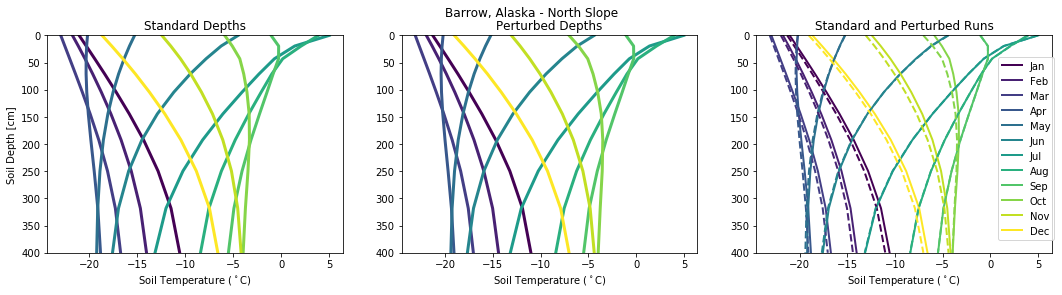

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# Barrow: 
nj_ind = 73
ni_ind = 130
lw = 3.0

colors_defrun = plt.matplotlib.cm.jet(np.linspace(0,1,12))
colors_pertrun = plt.matplotlib.cm.viridis(np.linspace(0, 1, 12))

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# default run
for mo_num in np.arange(0, 12):
    label = '%s' % months[mo_num]
    axes[0].plot(regrun_soil_profile[mo_num, :, nj_ind, ni_ind].values,
                 node_depths_cm,
                 color=colors_pertrun[mo_num], 
                 label=label, 
                 linewidth=lw)
axes[0].set_title('Standard Depths')
# axes[0].legend(loc='center left', bbox_to_anchor=(0.8, 0.58))
# plt.title('Barrow, Alaska North Slope (71.317, -156.600) \n (1978)')
axes[0].set_ylabel('Soil Depth [cm]')
axes[0].set_xlabel('Soil Temperature ($^\circ$C)')
axes[0].set_ylim([400, 0])

# perturbed run
for mo_num in np.arange(0, 12):
    label = '%s' % months[mo_num]
    axes[1].plot(pertrun_soil_profile[mo_num, :, nj_ind, ni_ind].values,
                 node_depths_cm,
                 color=colors_pertrun[mo_num], 
                 label=label, 
                 linewidth=lw)
axes[1].set_title('Perturbed Depths')
# axes[1].legend(loc='center left', bbox_to_anchor=(0.8, 0.58))
# plt.title('Barrow, Alaska North Slope (71.317, -156.600) \n (1978)')
axes[1].set_xlabel('Soil Temperature ($^\circ$C)')
axes[1].set_ylim([400, 0])

lw_both = 2.0

# both runs 
for mo_num in np.arange(0, 12):
    label = '%s' % months[mo_num]
    axes[2].plot(regrun_soil_profile[mo_num, :, nj_ind, ni_ind].values,
                 node_depths_cm,
                 color=colors_pertrun[mo_num], 
                 label=label, 
                 linewidth=lw_both)
axes[2].set_title('Default Run')
axes[2].legend(loc='center left', bbox_to_anchor=(0.8, 0.48))
# plt.title('Barrow, Alaska North Slope (71.317, -156.600) \n (1978)')
axes[2].set_xlabel('Soil Temperature ($^\circ$C)')

for mo_num in np.arange(0, 12):
    label = '%s' % months[mo_num]
    axes[2].plot(pertrun_soil_profile[mo_num, :, nj_ind, ni_ind].values,
                 node_depths_cm,
                 color=colors_pertrun[mo_num], 
                 label=label, 
                 linewidth=lw_both,
                 linestyle='--')
axes[2].set_title('Standard and Perturbed Runs')
axes[2].set_ylim([400, 0])

plt.suptitle('Barrow, Alaska - North Slope \n \n \n')


plotname = 'soil_temperature_profiles_barrow.png'
savepath = plot_direc
if not os.path.exists(savepath):
    os.makedirs(savepath)
plt.savefig(os.path.join(savepath, plotname), format='png', dpi=dpi, bbox_inches='tight')

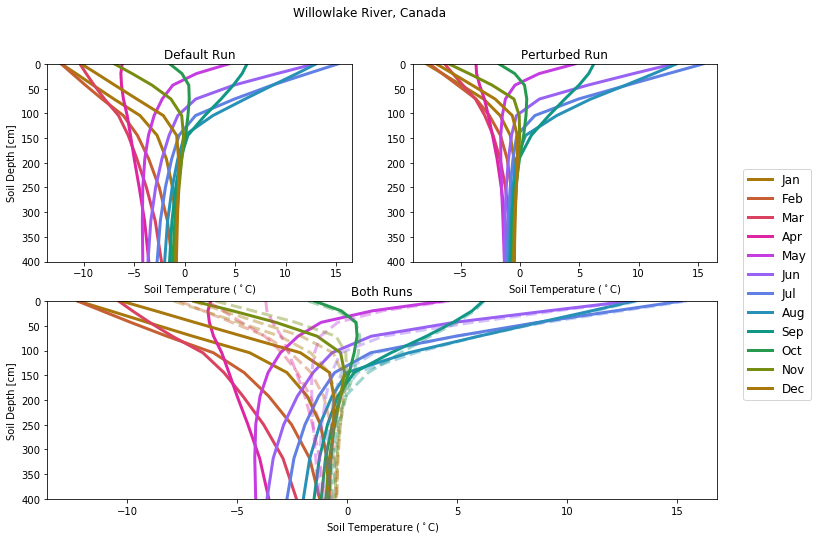

In [66]:
fig = plt.figure(figsize=(12, 8))

# Willowlake River, Canada: 62.6967, -123.065. (43, 148)
nj_ind = 43
ni_ind = 148
lw = 3.0

colors_defrun = plt.matplotlib.cm.jet(np.linspace(0,1,12))
# cmocean.cm.phase
colors_pertrun = cmocean.cm.phase(np.linspace(0, 1, 12))

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# default run
plt.subplot(221)

for mo_num in np.arange(0, 12):
    label = '%s' % months[mo_num]
    plt.plot(regrun_soil_profile[mo_num, :, nj_ind, ni_ind].values,
                 node_depths_cm,
                 color=colors_pertrun[mo_num], 
                 label=label, 
                 linewidth=lw)
plt.title('Default Run')
plt.ylabel('Soil Depth [cm]')
plt.xlabel('Soil Temperature ($^\circ$C)')
plt.ylim([400, 0])

# perturbed run
plt.subplot(222)

for mo_num in np.arange(0, 12):
    label = '%s' % months[mo_num]
    plt.plot(pertrun_soil_profile[mo_num, :, nj_ind, ni_ind].values,
                 node_depths_cm,
                 color=colors_pertrun[mo_num], 
                 label=label, 
                 linewidth=lw)
plt.title('Perturbed Run')
plt.xlabel('Soil Temperature ($^\circ$C)')
plt.ylim([400, 0])

lw_both = 3.0

# both runs 
plt.subplot(212)

for mo_num in np.arange(0, 12):
    label = '%s' % months[mo_num]
    plt.plot(regrun_soil_profile[mo_num, :, nj_ind, ni_ind].values,
                 node_depths_cm,
                 color=colors_pertrun[mo_num], 
                 label=label, 
                 linewidth=lw_both)
plt.title('Default Run')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1.7), prop={'size':12})
plt.xlabel('Soil Temperature ($^\circ$C)')
plt.ylabel('Soil Depth [cm]')

for mo_num in np.arange(0, 12):
    label = '%s' % months[mo_num]
    plt.plot(pertrun_soil_profile[mo_num, :, nj_ind, ni_ind].values,
                 node_depths_cm,
                 color=colors_pertrun[mo_num], 
                 label=label, 
                 linewidth=lw_both,
                 linestyle='--', 
                 alpha = 0.4)
plt.ylim([400, 0])
plt.title('Both Runs')

plt.suptitle('Willowlake River, Canada \n \n \n')

plotname = 'soil_temperature_profiles_willowlake_river_canada.png'
savepath = plot_direc
if not os.path.exists(savepath):
    os.makedirs(savepath)
plt.savefig(os.path.join(savepath, plotname), format='png', dpi=dpi, bbox_inches='tight')

In [23]:
# select 9th node for permafrost area calculations
soil_temps_node = monmean_soilnodetemp_regrun.isel(node=8)

In [24]:
# mean for each year 
annual_mean_temp_node = soil_temps_node.groupby('time.year').mean(dim='time')

In [25]:
# max across all years 
max_annual_mean_temp_node = annual_mean_temp_node.max(dim='year')
max_annual_mean_temp_node.coords['xc'] = file1.xc
max_annual_mean_temp_node.coords['yc'] = file1.yc

In [26]:
# min across all years
min_annual_mean_temp_node = annual_mean_temp_node.min(dim='year')
min_annual_mean_temp_node.coords['xc'] = file1.xc
min_annual_mean_temp_node.coords['yc'] = file1.yc

In [27]:
# figure out number of gridcells in RASM domain where there is permafrost 
# figure out number of gridcells where there is permafrost 
permafrost_mask = np.int32(max_annual_mean_temp_node <- 0)
no_gridcells_permafrost = permafrost_mask.sum()
area_permafrost = no_gridcells_permafrost * 2500.00 # 50km x 50km gridcells 
print ('We have {0:.2f} km2 of permafrost for these years in the RASM domain'.format(area_permafrost))
discont_permafrost_mask = np.int32(min_annual_mean_temp_node <- 0)

We have 23010000.00 km2 of permafrost for these years in the RASM domain


/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in less
  if not reflexive


## Figure of Continuous and Discontinuous Permafrost Across RASM Domain ## 

In [28]:
params = xr.open_dataset(os.path.join('/u/home/gergel','vic_params_wr50a_vic5.0.dev_20160328.nc'))
land_mask = params.run_cell
land_mask.coords['xc'] = params.xc
land_mask.coords['yc'] = params.yc

/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in less
  if not reflexive


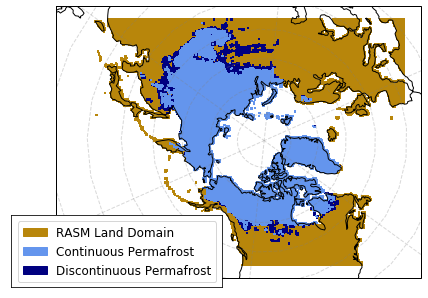

In [29]:
fig, ax = plt.subplots(figsize=(7, 5), subplot_kw=dict(projection=Rasm()))

land_color = "darkgoldenrod"
discont_color = "navy"
cont_color = "cornflowerblue"
cmap3 = colors.ListedColormap(land_color)    
cmap2 = colors.ListedColormap(discont_color)
cmap1 = colors.ListedColormap(cont_color)

land_mask.plot.pcolormesh('xc', 'yc', cmap=cmap3, 
                          add_colorbar=False, 
                          add_labels=False,
                          transform=ccrs.PlateCarree())
min_annual_mean_temp_node.where(min_annual_mean_temp_node <- 0).plot.pcolormesh('xc', 'yc',
                                                                                cmap=cmap2, 
                                                                                add_labels=False, 
                                                                                add_colorbar=False,
                                                                                transform=ccrs.PlateCarree())
max_annual_mean_temp_node.where(max_annual_mean_temp_node <- 0).plot.pcolormesh('xc', 'yc',
                                                                                cmap=cmap1, 
                                                                                add_labels=False, 
                                                                                add_colorbar=False,
                                                                                transform=ccrs.PlateCarree())
plt.setp(ax.get_yticklabels(), visible=False)
plt.setp(ax.get_xticklabels(), visible=False)
ax.tick_params(axis='both', which='both', length=0)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=1, color='gray', alpha=0.3, linestyle='--')

g1 = ax.coastlines()

# create patches for inset axes
p_land = mpatches.Patch(color=land_color, label='RASM Land Domain')
p_cont = mpatches.Patch(color=cont_color, label='Continuous Permafrost')
p_discont = mpatches.Patch(color=discont_color, label='Discontinuous Permafrost')

# this is an inset axes over the main axes
leg_axes = plt.axes([0.06, 0.1, .42, .2], facecolor='white')
leg_axes.legend(handles=[p_land, p_cont, p_discont], prop={'size':12})
plt.xticks([])
plt.yticks([])

plotname = 'permafrost_extent.png'
savepath = plot_direc
if not os.path.exists(savepath):
    os.makedirs(savepath)
plt.savefig(os.path.join(savepath, plotname), format='png', dpi=dpi, bbox_inches='tight')

## 35-year climatology of frozen area, with shaded area representing the range associated with interannual variability ##

In [30]:
min_months = soil_temps_node.groupby('time.month').min(dim='time')
mean_months = soil_temps_node.groupby('time.month').mean(dim='time')
max_months = soil_temps_node.groupby('time.month').max(dim='time')

In [31]:
# minimum temperatures corresponds to maximum permafrost area
min_area = []
for month in np.arange(0, 12): 
    permafrost_mask = np.int32(max_months.isel(month=month) <- 0)
    no_gridcells_permafrost = permafrost_mask.sum()
    area_permafrost = no_gridcells_permafrost * 2500.00 # 50km x 50km gridcells 
    min_area.append(area_permafrost)
    
# maximum temperatures corresponds to minimum permafrost area
max_area = []
for month in np.arange(0, 12): 
    permafrost_mask = np.int32(min_months.isel(month=month) <- 0)
    no_gridcells_permafrost = permafrost_mask.sum()
    area_permafrost = no_gridcells_permafrost * 2500.00 # 50km x 50km gridcells 
    max_area.append(area_permafrost)
mean_area = []
for month in np.arange(0, 12): 
    permafrost_mask = np.int32(mean_months.isel(month=month) <- 0)
    no_gridcells_permafrost = permafrost_mask.sum()
    area_permafrost = no_gridcells_permafrost * 2500.00 # 50km x 50km gridcells 
    mean_area.append(area_permafrost)

/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in less
  if not reflexive


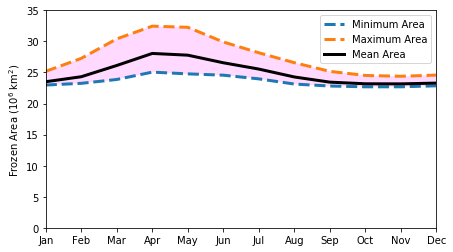

In [32]:
import matplotlib.ticker as mtick
unit_conv = 10 ** -6
lw = 3.0
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
month_nums = np.arange(0, 12)
max_area_conv = [i * unit_conv for i in max_area]
min_area_conv = [i * unit_conv for i in min_area]
mean_area_conv = [i * unit_conv for i in mean_area]
plt.plot(month_nums, min_area_conv, '--', linewidth=lw, label='Minimum Area')
plt.plot(month_nums, max_area_conv, '--', linewidth=lw, label='Maximum Area')
ax.fill_between(month_nums, min_area_conv, max_area_conv, facecolor="magenta", alpha=0.15)
plt.plot(month_nums, mean_area_conv, '-', linewidth=lw, color='k', label='Mean Area')
plt.ylabel("Frozen Area ($10^6$ $km^2$)")
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(month_nums, months, rotation='horizontal')
plt.legend(bbox_to_anchor=(1, 1))
plt.xlim([0, 11])
plt.ylim([0, 35])

plotname = 'permafrost_area_interannual_variability.png'
savepath = plot_direc
if not os.path.exists(savepath):
    os.makedirs(savepath)
plt.savefig(os.path.join(savepath, plotname), format='png', dpi=dpi, bbox_inches='tight')

active layer depth over the RASM domain

In [33]:
def spline_interp(x):
    if np.isnan(x).any() != True:
        tck = interpolate.splrep(node_depths, x, s=0)
        xnew = np.linspace(0, node_depths.max(), len(node_depths_arr)*20)
        ynew = interpolate.splev(xnew, tck, der=0)
        ind = np.argmin(np.abs(ynew))
        depth = xnew[ind]
        if x.values.max() < 0:
            # super cold temps, e.g. Greenland should have permafrost!
            return(xr.DataArray(0.0))
        elif x.values.min() > 0: 
            # temp close to 0 but no inflection point 
            return(xr.DataArray(-999))
        else:
            # return 0 deg isotherm depth associated with it
            return(xr.DataArray(depth))
    else: 
        return(xr.DataArray(-99.0))

## select out August from timeseries for ALT calculations ##

process for regular run 

In [34]:
def is_august(month):
    ''' this function returns True if the month is August and False if not'''
    return (month == 8) 

august_mean_soil_temp = monmean_soilnodetemp_regrun.sel(time=is_august(monmean_soilnodetemp_regrun['time.month']))

august_mean_soil_temp_pertrun = monmean_soilnodetemp_pertrun.sel(time=is_august(monmean_soilnodetemp_pertrun['time.month']))

In [35]:
'''# stack time, lat and lon into a single dimension called allpoints
stacked_da = august_mean_soil_temp.stack(allpoints=['time', 'nj', 'ni'])

# apply the function over allpoints to calculate the 0 degree isotherm at each time-space point 
alt_stacked = stacked_da.groupby('allpoints').apply(spline_interp)

# unstack it to be a space-time DataArray 
alt_unstacked = alt_stacked.unstack('allpoints')

# groupby year, take max across all months in a year, and then take the mean ALT across all years 
annual_max_alt = alt_unstacked.mean(dim='time')
# add xc and yc coordinates for use in pcolormesh
annual_max_alt.coords['xc'] = file1.xc
annual_max_alt.coords['yc'] = file1.yc'''

"# stack time, lat and lon into a single dimension called allpoints\nstacked_da = august_mean_soil_temp.stack(allpoints=['time', 'nj', 'ni'])\n\n# apply the function over allpoints to calculate the 0 degree isotherm at each time-space point \nalt_stacked = stacked_da.groupby('allpoints').apply(spline_interp)\n\n# unstack it to be a space-time DataArray \nalt_unstacked = alt_stacked.unstack('allpoints')\n\n# groupby year, take max across all months in a year, and then take the mean ALT across all years \nannual_max_alt = alt_unstacked.mean(dim='time')\n# add xc and yc coordinates for use in pcolormesh\nannual_max_alt.coords['xc'] = file1.xc\nannual_max_alt.coords['yc'] = file1.yc"

process for perturbed run

In [36]:
'''august_mean_soil_temp_pertrun = monmean_soilnodetemp_pertrun.sel(time=is_august(monmean_soilnodetemp_pertrun['time.month']))

stacked_da_pertrun = august_mean_soil_temp_pertrun.stack(allpoints=['time', 'nj', 'ni'])

alt_stacked_pertrun = stacked_da_pertrun.groupby('allpoints').apply(spline_interp)

# unstack it to be a space-time DataArray 
alt_unstacked_pertrun = alt_stacked_pertrun.unstack('allpoints')
# groupby year, take max across all months in a year, and then take the mean ALT across all years 
annual_max_alt_pertrun = alt_unstacked_pertrun.mean(dim='time')
# add xc and yc coordinates for use in pcolormesh
annual_max_alt_pertrun.coords['xc'] = file1.xc
annual_max_alt_pertrun.coords['yc'] = file1.yc'''

"august_mean_soil_temp_pertrun = monmean_soilnodetemp_pertrun.sel(time=is_august(monmean_soilnodetemp_pertrun['time.month']))\n\nstacked_da_pertrun = august_mean_soil_temp_pertrun.stack(allpoints=['time', 'nj', 'ni'])\n\nalt_stacked_pertrun = stacked_da_pertrun.groupby('allpoints').apply(spline_interp)\n\n# unstack it to be a space-time DataArray \nalt_unstacked_pertrun = alt_stacked_pertrun.unstack('allpoints')\n# groupby year, take max across all months in a year, and then take the mean ALT across all years \nannual_max_alt_pertrun = alt_unstacked_pertrun.mean(dim='time')\n# add xc and yc coordinates for use in pcolormesh\nannual_max_alt_pertrun.coords['xc'] = file1.xc\nannual_max_alt_pertrun.coords['yc'] = file1.yc"

In [37]:
# load above ALT that has been calculated and saved to a NetCDF already 
modeled_alt = xr.open_dataset(os.path.join('/u/home/gergel/agu_runs', 'modeled_alt_1989_2016.nc'))
annual_max_alt_pertrun = modeled_alt.ALT_PERTURBED
annual_max_alt = modeled_alt.ALT_DEFAULT

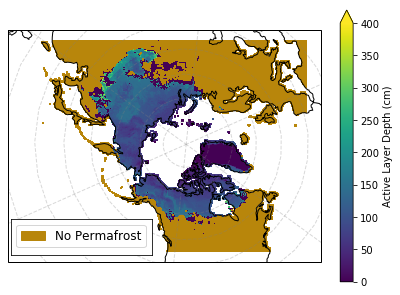

In [38]:
fig, ax = plt.subplots(figsize=(7, 5), subplot_kw=dict(projection=Rasm()))

(annual_max_alt.where((annual_max_alt != -99) & (annual_max_alt != -999)) * 100).plot.pcolormesh('xc', 'yc',
                                                                                              robust=True, 
                                                                    cbar_kwargs={'label': 'Active Layer Depth (cm)', 
                                                                                 'extend': 'max'}, 
                                                                                              add_labels=False, 
                                                                    transform=ccrs.PlateCarree(),
                                                                    vmin=0, 
                                                                    vmax=400)

annual_max_alt.where(annual_max_alt == -999).plot.pcolormesh('xc', 'yc',
                                                           cmap=cmap3, 
                                                           add_colorbar=False, 
                                                           add_labels=False,
                                                           transform=ccrs.PlateCarree())

plt.setp(ax.get_yticklabels(), visible=False)
plt.setp(ax.get_xticklabels(), visible=False)
ax.tick_params(axis='both', which='both', length=0)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=1, color='gray', alpha=0.3, linestyle='--')

g1 = ax.coastlines()

# create land line patch for inset axes
p = mpatches.Patch(color=land_color, label='No Permafrost')

# this is an inset axes over the main axes
leg_axes = plt.axes([0.13, 0.2, .28, .1], facecolor='white')
leg_axes.legend(handles=[p], prop={'size':12})
plt.xticks([])
plt.yticks([])

plotname = 'modeled_alt_rasm_domain.png'
savepath = plot_direc
if not os.path.exists(savepath):
    os.makedirs(savepath)
plt.savefig(os.path.join(savepath, plotname), format='png', dpi=dpi, bbox_inches='tight')

In [39]:
hydra_direc = '/u/home/gergel/from_hydra'

# new files 
domain_file = 'calm_domain_file_adj_11282016.nc'
params_ncfile = 'params_calm_sites_11282016.nc'

domain = xr.open_dataset(os.path.join(hydra_direc, domain_file))

# load separate copy of the domain file to alter with thaw depths for obs and model runs (one for each, 
# can then calculate the difference but I want to see both independently too)

obs_thaw_depths = xr.open_dataset(os.path.join(hydra_direc, domain_file))

# obs from CALM network
thaw_depths_file = 'thaw_depths.csv'
thaw_depths = pd.read_csv(os.path.join(hydra_direc, thaw_depths_file), 
                          delimiter=',', 
                         header=None, 
                         error_bad_lines=False, 
                         nrows=236, 
                         encoding='ISO-8859-1')
calm_metadata = 'CALM_Summary_table_latslons.csv'

# read in data
calm = pd.read_csv(os.path.join(hydra_direc, calm_metadata), 
                   delimiter=',',
                   header=0,
                   error_bad_lines=False,
                   nrows=236,
                   encoding='ISO-8859-1')

# rename columns 
calm.rename(index=str, columns={"LAT": "lat", "LONG": "lng"}, inplace=True)

In [40]:
def parse_calm_lat_or_lon(x):
    '''takes in lat or lon from CALM data and produces list of degree, minutes, seconds
    or decimal. If element is a decimal, returns decimal as a float. If not decimal, 
    or decimal with direction, it returns a decimal without the direction as a float'''
    # symbols to parse by
    upside_down_exc = '¡'
    degree_sign= u'\N{DEGREE SIGN}'
    single_quote = "'"
    double_quote = '''"'''
    space = " "
    comma = ","
    v = 'v'
    zero_aigu = calm['lat'][70][8]
    # combine all symbols into one reg ex
    split_on = '%s|\s|%s|%s|%s|%s|%s|%s|%s|' % (upside_down_exc, degree_sign, single_quote, 
                                             double_quote, space, comma, v, zero_aigu)
    # parse lat or lon with reg ex 
    splitt = re.split(split_on, x)

    # remove comma and v characters from strings in parsed list 
    chars_to_remove = [',' 'v']
    for char_to_remove in chars_to_remove:
        if char_to_remove in splitt: 
            splitt.remove(char_to_remove)
            
    # remove empty strings from parsed list 
    parsed_list = list(filter(None, splitt))

    # 4 cases 
    if len(parsed_list) == 1:
        # decimal so leave as is but convert to float
        return(float(parsed_list[0]))
    elif len(parsed_list) == 2: 
        # decimal with direction, remove direction, return first element as float
        # with the correct sign 
        direction = parsed_list[1]
        if direction == "S" or direction == "W": 
            return(float(parsed_list[0]) *-1)
        else: 
            return(float(parsed_list[0]))
    else:
        # degree, min, sec OR min, sec; convert to decimal. 
        if len(parsed_list) == 3:
            # case with no minutes
            dd = float(parsed_list[0]) + float(parsed_list[1])/60.0
            direction = parsed_list[2]
        elif len(parsed_list) == 4:
            # case where minutes are included
            '''print(parsed_list[2])
            print(type(parsed_list[2][2][0]))'''
            dd = (float(parsed_list[0]) + float(parsed_list[1])/60.0 
                  + float(parsed_list[2])/(60.0*60.0))
            direction = parsed_list[3]
        if direction == "S" or direction == "W":
            dd *= -1
        return(dd)
    
def convert_longitude_0_360(longitude):
    ''' takes in longitude between -180 to 180 and converts it to the 0 to 360 longitude'''
    lng = np.mod(longitude, 360)
    return lng 

In [41]:
# convert lats/lons from degree minute second to decimal format
calm['lat_dec'] = calm['lat'].apply(parse_calm_lat_or_lon)
calm['lng_dec'] = calm['lng'].apply(parse_calm_lat_or_lon)

# add column to DataFrame with longitudes from 0 to 360
calm['lng_dec_360'] = calm['lng_dec'].apply(convert_longitude_0_360)

/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


In [42]:
thaw_depths = pd.read_csv(os.path.join(hydra_direc, thaw_depths_file), 
                          delimiter=',', 
                         header=None, 
                         error_bad_lines=False, 
                         nrows=236, 
                         encoding='ISO-8859-1')

def replace_dash_with_nan(x): 
    '''this function replaces hyphens in the observed thaw depth time series with NaNs'''
    # print(type(x))
    if (type(x) == str):
        if ('-' in x):
            return np.nan
        elif thaw_depths.iloc[99][18][0] in x: 
            return(x.replace(thaw_depths.iloc[99][18][0], ""))
        elif x == ' ':
            return np.nan
        else: 
            return x
    else: 
        return np.nan
    
thaw_depths_filtered = thaw_depths.applymap(replace_dash_with_nan)
# print(thaw_depths_filtered.iloc[181][6] == ' ')
thaw_depths_observed = []

for latlng in np.arange(0, thaw_depths_filtered.shape[0]):
    thaw_depth_observed = np.nanmean(np.array(thaw_depths_filtered.iloc[latlng]).astype(float))
    thaw_depths_observed = np.append(thaw_depths_observed, thaw_depth_observed)

/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice


In [43]:
# loop over all calm obs sites

obs_dataset = domain.copy()

# save all points
nj_inds = []
ni_inds = []
thaw_depth_list = []

for latlng in range(0, len(calm['lat_dec'])):

    lat = calm['lat_dec'][latlng]
    lng = calm['lng_dec_360'][latlng]

    # initialize array of maximum annual thaw depths 
    # annual_max_thaw_depths = []

    # get index 
    min_arg = (((domain.xc - lng)**2) + ((domain.yc - lat)**2)).argmin()
    nj_ind, ni_ind = np.unravel_index(min_arg, domain.xc.shape)
    # node_depths = node_state.node_depth[:, nj_ind, ni_ind]

    # loop over years and calculate maximum annual thaw depths 
    '''for year in range(1978, 2009): 
        year_start = '%s-01-01' % year
        year_end = '%s-12-31' %year

        # initialize array of zero depths for the year (so that we can then find the max)
        node_depths_ts = []

        for month in np.arange(0, 12):
            # time_step = mo_fluxes.OUT_SOIL_TNODE[:, :, nj_ind, ni_ind].sel(time=slice(year_start, year_end))[month]
            # sum_over_zero = np.sum(time_step.values >= 0)
            if sum_over_zero == 0: 
                thaw_depth = 0
            else: 
                thaw_depth = node_depths.values[sum_over_zero - 1] * 100.0 # in m, convert to cm
            node_depths_ts = np.append(node_depths_ts, thaw_depth)

        # annual_max_thaw_depths = np.append(annual_max_thaw_depths, node_depths_ts.max())'''
    
    # alter sim mask variable with average annual maximum thaw depth
    # sim_thaw_depths.mask[nj_ind, ni_ind] = annual_max_thaw_depths.mean()
    print("completed %f %f %f" %(latlng, calm['lat_dec'][latlng], calm['lng_dec_360'][latlng]))
    nj_inds.append(nj_ind)
    ni_inds.append(ni_ind)
    # obs_dataset[nj_ind, ni_ind].values = 
    # thaw_depth_list.append(annual_max_thaw_depths.mean())

completed 0.000000 71.316667 203.400000
completed 1.000000 71.316667 203.416667
completed 2.000000 70.450000 202.600000
completed 3.000000 70.366667 211.450000
completed 4.000000 70.366667 211.433333
completed 5.000000 70.166667 211.533333
completed 6.000000 70.283333 211.133333
completed 7.000000 70.283500 211.107200
completed 8.000000 70.275000 211.081000
completed 9.000000 69.683333 211.283333
completed 10.000000 69.166667 211.166667
completed 11.000000 69.100000 211.500000
completed 12.000000 69.128830 211.407200
completed 13.000000 68.500000 210.500000
completed 14.000000 68.611000 210.685500
completed 15.000000 68.611000 210.690670
completed 16.000000 68.616667 210.400000
completed 17.000000 68.624000 210.381830
completed 18.000000 68.616667 210.400000
completed 19.000000 68.483333 210.500000
completed 20.000000 68.066667 210.416667
completed 21.000000 68.483333 204.266667
completed 22.000000 69.696900 211.317900
completed 23.000000 69.441000 211.329670
completed 24.000000 69.401

completed 209.000000 50.044440 100.732780
completed 210.000000 50.044170 100.754440
completed 211.000000 51.031110 100.722500
completed 212.000000 51.355560 99.359170
completed 213.000000 51.187220 99.497500
completed 214.000000 51.114720 99.636940
completed 215.000000 51.358610 99.479720
completed 216.000000 47.980280 100.425280
completed 217.000000 47.979440 100.425560
completed 218.000000 48.275280 106.194720
completed 219.000000 49.347220 99.242220
completed 220.000000 49.296940 98.190000
completed 221.000000 50.933333 121.333333
completed 222.000000 34.333333 97.866667
completed 223.000000 34.733333 92.883333
completed 224.000000 35.433333 93.600000
completed 225.000000 34.466667 92.733333
completed 226.000000 31.816667 91.733333
completed 227.000000 35.616667 94.066667
completed 228.000000 43.216667 87.116667
completed 229.000000 43.116667 86.850000
completed 230.000000 43.116667 86.850000
completed 231.000000 43.100000 86.816667
completed 232.000000 43.083333 76.916667
completed

In [44]:
domain = xr.open_dataset(os.path.join(hydra_direc, domain_file))
obs_dataset = domain.copy()

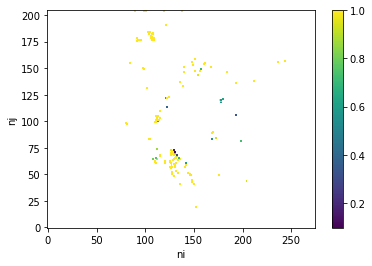

In [45]:
obs_dataset.frac.where(obs_dataset.mask == 1).plot()

In [46]:
for calm_site in np.arange(0, len(nj_inds)): 
    obs_dataset['frac'].values[nj_inds[calm_site], ni_inds[calm_site]] = thaw_depths_observed[calm_site]

In [47]:
observed_alt = obs_dataset.frac.where(obs_dataset.mask == 1)
observed_alt.coords['xc'] = file1.xc
observed_alt.coords['yc'] = file1.yc

figure with modeled and observed together for default run

/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in greater
  if not reflexive


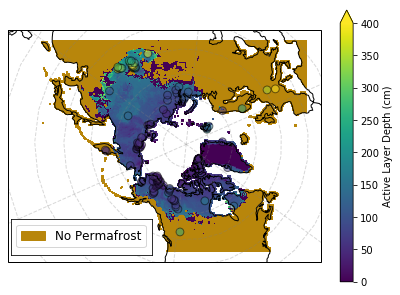

In [48]:
fig, ax = plt.subplots(figsize=(7, 5), subplot_kw=dict(projection=Rasm()))

(annual_max_alt.where((annual_max_alt != -99) & (annual_max_alt != -999)) * 100).plot.pcolormesh('xc', 'yc',
                                                                                              robust=True, 
                                                                    cbar_kwargs={'label': 'Active Layer Depth (cm)', 
                                                                                 'extend': 'max'}, 
                                                                                              add_labels=False, 
                                                                    transform=ccrs.PlateCarree(),
                                                                    vmin=0, 
                                                                    vmax=400)

annual_max_alt.where(annual_max_alt == -999).plot.pcolormesh('xc', 'yc',
                                                           cmap=cmap3, 
                                                           add_colorbar=False, 
                                                           add_labels=False,
                                                           transform=ccrs.PlateCarree())

plt.setp(ax.get_yticklabels(), visible=False)
plt.setp(ax.get_xticklabels(), visible=False)
ax.tick_params(axis='both', which='both', length=0)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=1, color='gray', alpha=0.3, linestyle='--')

g1 = ax.coastlines()

# create land line patch for inset axes
p = mpatches.Patch(color=land_color, label='No Permafrost')

# this is an inset axes over the main axes
leg_axes = plt.axes([0.13, 0.2, .28, .1], facecolor='white')
leg_axes.legend(handles=[p], prop={'size':12})
plt.xticks([])
plt.yticks([])

alpha = 0.5
ax.scatter(observed_alt.xc.where((observed_alt > 0) & (observed_alt.nj < 200)), 
            observed_alt.yc.where((observed_alt > 0) & (observed_alt.nj < 200)),
            c=observed_alt.where((observed_alt > 0) & (observed_alt.nj < 200)), 
            s=60,
            cmap=plt.cm.viridis,
            marker='o', 
            edgecolor='k',
            alpha=alpha, 
            vmin=0, 
            vmax=400,
            transform=ccrs.PlateCarree())

plotname = 'modeled_and_observed_alt_rasm_domain.png'
savepath = plot_direc
if not os.path.exists(savepath):
    os.makedirs(savepath)
plt.savefig(os.path.join(savepath, plotname), format='png', dpi=dpi, bbox_inches='tight')

two figures: one for just ALT, one for perturbation experiment and highlighting differences 

/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in greater
  if not reflexive


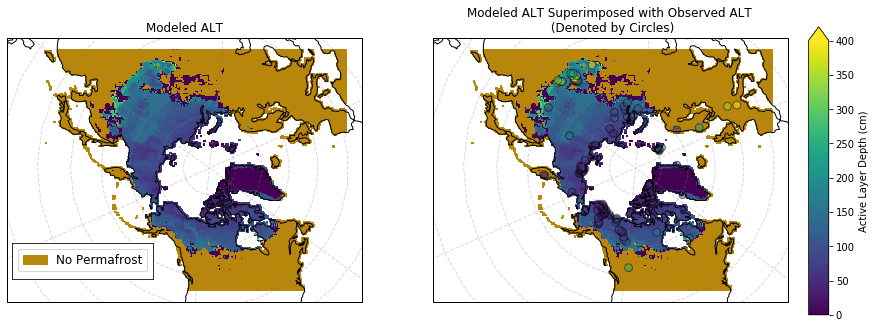

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5), subplot_kw=dict(projection=Rasm()))

# first subplot
(annual_max_alt.where((annual_max_alt != -99) & (annual_max_alt != -999)) * 100).plot.pcolormesh('xc', 'yc',
                                                                                              robust=True, 
                                                                                              add_colorbar=False,
                                                                                              add_labels=False, 
                                                                    transform=ccrs.PlateCarree(),
                                                                    vmin=0, 
                                                                    vmax=400, 
                                                                    ax=ax[0])

annual_max_alt.where(annual_max_alt == -999).plot.pcolormesh('xc', 'yc',
                                                           cmap=cmap3, 
                                                           add_colorbar=False, 
                                                           add_labels=False,
                                                           transform=ccrs.PlateCarree(), 
                                                           ax=ax[0])

plt.setp(ax[0].get_yticklabels(), visible=False)
plt.setp(ax[0].get_xticklabels(), visible=False)
ax[0].tick_params(axis='both', which='both', length=0)

gl = ax[0].gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=1, color='gray', alpha=0.3, linestyle='--')

g1 = ax[0].coastlines()

ax[0].set_title('Modeled ALT')

# create land line patch for inset axes
p = mpatches.Patch(color=land_color, label='No Permafrost')

# this is an inset axes over the main axes
leg_axes = plt.axes([0.13, 0.2, .14, .1], facecolor='white')
leg_axes.legend(handles=[p], prop={'size':12})
plt.xticks([])
plt.yticks([])

# create axis for colorbar 
cbar_ax = plt.axes([0.92, 0.1, 0.02, 0.8])

# second subplot

img = (annual_max_alt.where((annual_max_alt != -99) & (annual_max_alt != -999)) * 100).plot.pcolormesh('xc', 'yc',
                                                                                              robust=True, 
                                                                                              cbar_ax=cbar_ax,
                                                                                              add_labels=False, 
                                                    cbar_kwargs={'label': 'Active Layer Depth (cm)', 'extend': 'max'},
                                                                    transform=ccrs.PlateCarree(),
                                                                    vmin=0, 
                                                                    vmax=400, 
                                                                    ax=ax[1])
# colorbar: cbar_kwargs={'label': 'Active Layer Depth (cm)', 'extend': 'max'},

annual_max_alt.where(annual_max_alt == -999).plot.pcolormesh('xc', 'yc',
                                                           cmap=cmap3, 
                                                           add_colorbar=False, 
                                                           add_labels=False,
                                                           transform=ccrs.PlateCarree(), 
                                                           ax=ax[1])

plt.setp(ax[1].get_yticklabels(), visible=False)
plt.setp(ax[1].get_xticklabels(), visible=False)
ax[1].tick_params(axis='both', which='both', length=0)

gl = ax[1].gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=1, color='gray', alpha=0.3, linestyle='--')

g1 = ax[1].coastlines()

alpha = 0.5
ax[1].scatter(observed_alt.xc.where((observed_alt > 0) & (observed_alt.nj < 200)), 
            observed_alt.yc.where((observed_alt > 0) & (observed_alt.nj < 200)),
            c=observed_alt.where((observed_alt > 0) & (observed_alt.nj < 200)), 
            s=60,
            cmap=plt.cm.viridis,
            marker='o', 
            edgecolor='k',
            alpha=alpha, 
            vmin=0, 
            vmax=400,
            transform=ccrs.PlateCarree())

ax[1].set_title('Modeled ALT Superimposed with Observed ALT \n (Denoted by Circles)')

plotname = 'twopanelfigure_modeled_and_observed_alt_rasm_domain.png'
savepath = plot_direc
if not os.path.exists(savepath):
    os.makedirs(savepath)
plt.savefig(os.path.join(savepath, plotname), format='png', dpi=dpi, bbox_inches='tight')

three panel figure: modeled from perturbed, modeled superimposed with obs, and diff between default and perturbed

In [50]:
# diff_alt = xr.diff(annual_max_alt - annual_max_alt_pertrun)

/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in greater
  if not reflexive


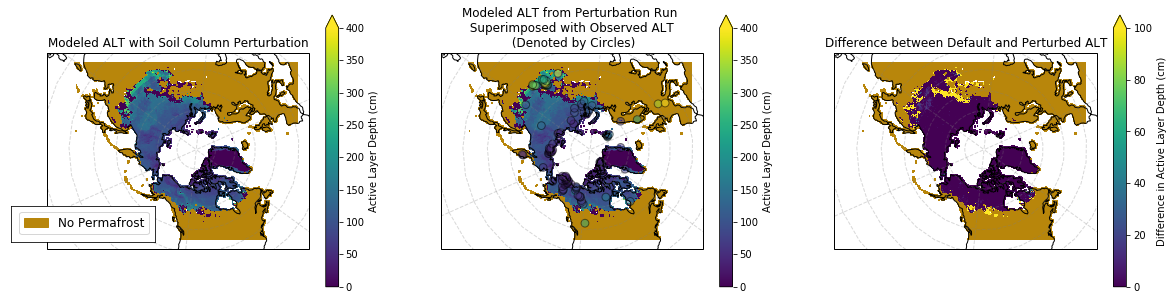

In [51]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5), subplot_kw=dict(projection=Rasm()))

# first subplot
(annual_max_alt_pertrun.where((annual_max_alt_pertrun != -99) & (annual_max_alt_pertrun != -999)) * 100).plot.pcolormesh('xc', 'yc',
                                                                                              robust=True, 
                                                                                              add_labels=False, 
                                                                    transform=ccrs.PlateCarree(),
                                                    cbar_kwargs={'label': 'Active Layer Depth (cm)', 'extend': 'max'},
                                                                    vmin=0, 
                                                                    vmax=400, 
                                                                    ax=ax[0])

annual_max_alt_pertrun.where(annual_max_alt == -999).plot.pcolormesh('xc', 'yc',
                                                           cmap=cmap3, 
                                                           add_colorbar=False, 
                                                           add_labels=False,
                                                           transform=ccrs.PlateCarree(), 
                                                           ax=ax[0])

plt.setp(ax[0].get_yticklabels(), visible=False)
plt.setp(ax[0].get_xticklabels(), visible=False)
ax[0].tick_params(axis='both', which='both', length=0)

gl = ax[0].gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=1, color='gray', alpha=0.3, linestyle='--')

g1 = ax[0].coastlines()

ax[0].set_title('Modeled ALT with Soil Column Perturbation')

# create land line patch for inset axes
p = mpatches.Patch(color=land_color, label='No Permafrost')

# this is an inset axes over the main axes
leg_axes = plt.axes([0.1, 0.25, .1, .1], facecolor='white')
leg_axes.legend(handles=[p], prop={'size':12})
plt.xticks([])
plt.yticks([])

# second subplot

(annual_max_alt_pertrun.where((annual_max_alt_pertrun != -99) & (annual_max_alt_pertrun != -999)) * 100).plot.pcolormesh('xc', 'yc',
                                                                                              robust=True, 
                                                                                              add_labels=False, 
                                                    cbar_kwargs={'label': 'Active Layer Depth (cm)', 'extend': 'max'},
                                                                    transform=ccrs.PlateCarree(),
                                                                    vmin=0, 
                                                                    vmax=400, 
                                                                    ax=ax[1])
# colorbar: cbar_kwargs={'label': 'Active Layer Depth (cm)', 'extend': 'max'},

annual_max_alt_pertrun.where(annual_max_alt == -999).plot.pcolormesh('xc', 'yc',
                                                           cmap=cmap3, 
                                                           add_colorbar=False, 
                                                           add_labels=False,
                                                           transform=ccrs.PlateCarree(), 
                                                           ax=ax[1])

plt.setp(ax[1].get_yticklabels(), visible=False)
plt.setp(ax[1].get_xticklabels(), visible=False)
ax[1].tick_params(axis='both', which='both', length=0)

gl = ax[1].gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=1, color='gray', alpha=0.3, linestyle='--')

g1 = ax[1].coastlines()

alpha = 0.5
ax[1].scatter(observed_alt.xc.where((observed_alt > 0) & (observed_alt.nj < 200)), 
            observed_alt.yc.where((observed_alt > 0) & (observed_alt.nj < 200)),
            c=observed_alt.where((observed_alt > 0) & (observed_alt.nj < 200)), 
            s=60,
            cmap=plt.cm.viridis,
            marker='o', 
            edgecolor='k',
            alpha=alpha, 
            vmin=0, 
            vmax=400,
            transform=ccrs.PlateCarree())

ax[1].set_title('Modeled ALT from Perturbation Run \n Superimposed with Observed ALT \n (Denoted by Circles)')

# subplot 3: difference between default and perturbed runs in ALT

diff_alt = ((annual_max_alt.where((annual_max_alt != -99) & (annual_max_alt != -999)) * 100) - 
            (annual_max_alt_pertrun.where((annual_max_alt_pertrun != -99) & (annual_max_alt_pertrun != -999)) * 100))

diff_alt.plot.pcolormesh('xc', 'yc',
                         robust=True, 
                         add_labels=False, 
                         cbar_kwargs={'label': 'Difference in Active Layer Depth (cm)', 'extend': 'max'},
                         transform=ccrs.PlateCarree(), 
                         ax=ax[2], 
                         vmin=0, 
                         vmax=100)

annual_max_alt_pertrun.where(annual_max_alt == -999).plot.pcolormesh('xc', 'yc',
                                                           cmap=cmap3, 
                                                           add_colorbar=False, 
                                                           add_labels=False,
                                                           transform=ccrs.PlateCarree(), 
                                                           ax=ax[2])

plt.setp(ax[2].get_yticklabels(), visible=False)
plt.setp(ax[2].get_xticklabels(), visible=False)
ax[2].tick_params(axis='both', which='both', length=0)

gl = ax[2].gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=1, color='gray', alpha=0.3, linestyle='--')

g1 = ax[2].coastlines()

ax[2].set_title('Difference between Default and Perturbed ALT')

alpha = 0.5

plotname = 'perturbed_threepanelfigure_modeled_and_observed_alt_rasm_domain.png'
savepath = plot_direc
if not os.path.exists(savepath):
    os.makedirs(savepath)
plt.savefig(os.path.join(savepath, plotname), format='png', dpi=dpi, bbox_inches='tight')

save ALT from default run to NetCDF for future use (so I don't have to recalculate it every time I run this notebook)

In [52]:
ds_default_alt = xr.Dataset(data_vars={'ALT_DEFAULT': annual_max_alt}, 
                            coords={'xc': annual_max_alt.xc, 'yc': annual_max_alt.yc})

In [53]:
# ds_default_alt.to_netcdf(os.path.join('/u/home/gergel/agu_runs/default_run', 'modeled_default_alt_1989_2016.nc'))

In [54]:
ds_alt = xr.Dataset(data_vars={'ALT_DEFAULT': annual_max_alt, 'ALT_PERTURBED': annual_max_alt_pertrun}, 
                            coords={'xc': annual_max_alt.xc, 'yc': annual_max_alt.yc})

compare default with perturbed runs visually (and to make sure that I didn't accidentally use the default as the perturbed) 

perturbed run

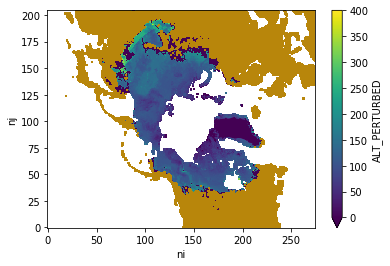

In [55]:
(ds_alt.ALT_PERTURBED.where((ds_alt.ALT_PERTURBED != -99) & (ds_alt.ALT_PERTURBED != -999)) * 100).plot(vmin=0, 
                                                                                                        vmax=400)
ds_alt.ALT_PERTURBED.where(ds_alt.ALT_PERTURBED == -999).plot(add_colorbar=False, cmap=cmap3)

default run 

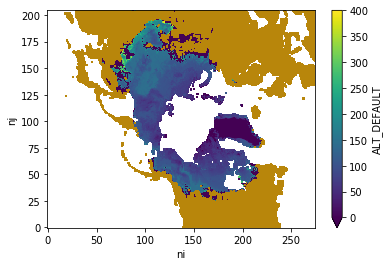

In [56]:
(ds_alt.ALT_DEFAULT.where((ds_alt.ALT_DEFAULT != -99) & (ds_alt.ALT_DEFAULT != -999)) * 100).plot(vmin=0, 
                                                                                                        vmax=400)
ds_alt.ALT_DEFAULT.where(ds_alt.ALT_DEFAULT == -999).plot(add_colorbar=False, cmap=cmap3)

save default and perturbed ALT to same NetCDF so that this notebook doesn't take hours to run 

In [57]:
'''ds_alt.to_netcdf(os.path.join('/u/home/gergel/agu_runs', 'modeled_alt_1989_2016.nc'))
alt_filepath = os.path.join('/u/home/gergel/agu_runs', 'modeled_alt_1989_2016.nc')
print('saving ALT from Default and Perturbed Runs to {}'.format(alt_filepath))'''

"ds_alt.to_netcdf(os.path.join('/u/home/gergel/agu_runs', 'modeled_alt_1989_2016.nc'))\nalt_filepath = os.path.join('/u/home/gergel/agu_runs', 'modeled_alt_1989_2016.nc')\nprint('saving ALT from Default and Perturbed Runs to {}'.format(alt_filepath))"

## compare (with scatterplots) modeled to observed ALT for both default and perturbation runs ## 

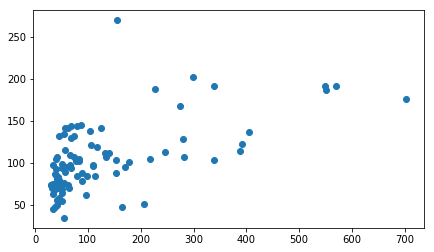

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
alt_default_values = annual_max_alt.where((domain.mask == 1) & (annual_max_alt > 0), drop=True).values
alt_perturbed_values = annual_max_alt_pertrun.where((domain.mask == 1) & (annual_max_alt > 0), drop=True).values
alt_observed_values = observed_alt.where((domain.mask == 1) & (annual_max_alt > 0), drop=True).values
plt.scatter(alt_observed_values, alt_default_values * 100)

/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in less_equal
  if not reflexive
/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in greater
  if not reflexive
/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in less_equal
  if not reflexive
/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in greater
  if not reflexive


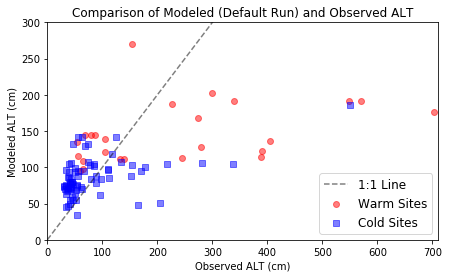

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

t = -5

alt_default_values_cold = annual_max_alt.where((domain.mask == 1) & (annual_max_alt > 0) & (params.avg_T <= t), 
                                                  drop=True).values
alt_default_values_warm = annual_max_alt.where((domain.mask == 1) & (annual_max_alt > 0) & (params.avg_T > t), 
                                                  drop=True).values

alt_observed_values_cold = observed_alt.where((domain.mask == 1) & (annual_max_alt > 0) & (params.avg_T <= t), 
                                         drop=True).values
alt_observed_values_warm = observed_alt.where((domain.mask == 1) & (annual_max_alt > 0) & (params.avg_T > t), 
                                         drop=True).values

alpha = 0.5

ax.scatter(alt_observed_values_warm, alt_default_values_warm * 100, color='red', marker='o', label='Warm Sites', 
           alpha=alpha)
ax.scatter(alt_observed_values_cold, alt_default_values_cold * 100, color='blue', marker='s', label='Cold Sites', 
           alpha=alpha)

ax.plot(np.arange(0, 700), np.arange(0, 700), '--', color='k', alpha=alpha, label='1:1 Line')

ax.set_xlabel('Observed ALT (cm)')
ax.set_ylabel('Modeled ALT (cm)')
ax.set_title('Comparison of Modeled (Default Run) and Observed ALT')
ax.legend(loc='lower right', prop={'size': 12})
ax.set_ylim([0, 300])
ax.set_xlim([0, 710])

plotname = 'scatter_plot_modeled_default_observed_alt.png'
savepath = plot_direc
if not os.path.exists(savepath):
    os.makedirs(savepath)
plt.savefig(os.path.join(savepath, plotname), format='png', dpi=dpi, bbox_inches='tight')

/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in less_equal
  if not reflexive
/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in greater
  if not reflexive
/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in less_equal
  if not reflexive
/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in greater
  if not reflexive


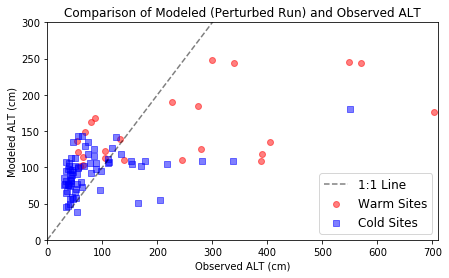

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

t = -5

alt_perturbed_values_cold = annual_max_alt_pertrun.where((domain.mask == 1) & (annual_max_alt_pertrun > 0) & (params.avg_T <= t), 
                                                  drop=True).values
alt_perturbed_values_warm = annual_max_alt_pertrun.where((domain.mask == 1) & (annual_max_alt_pertrun > 0) & (params.avg_T > t), 
                                                  drop=True).values

alt_observed_values_cold = observed_alt.where((domain.mask == 1) & (annual_max_alt_pertrun > 0) & (params.avg_T <= t), 
                                         drop=True).values
alt_observed_values_warm = observed_alt.where((domain.mask == 1) & (annual_max_alt_pertrun > 0) & (params.avg_T > t), 
                                         drop=True).values

alpha = 0.5

ax.scatter(alt_observed_values_warm, alt_perturbed_values_warm * 100, color='red', marker='o', label='Warm Sites', 
           alpha=alpha)
ax.scatter(alt_observed_values_cold, alt_perturbed_values_cold * 100, color='blue', marker='s', label='Cold Sites', 
           alpha=alpha)

ax.plot(np.arange(0, 700), np.arange(0, 700), '--', color='k', alpha=alpha, label='1:1 Line')

ax.set_xlabel('Observed ALT (cm)')
ax.set_ylabel('Modeled ALT (cm)')
ax.set_title('Comparison of Modeled (Perturbed Run) and Observed ALT')
ax.legend(loc='lower right', prop={'size': 12})
ax.set_ylim([0, 300])
ax.set_xlim([0, 710])

plotname = 'scatter_plot_modeled_perturbed_observed_alt.png'
savepath = plot_direc
if not os.path.exists(savepath):
    os.makedirs(savepath)
plt.savefig(os.path.join(savepath, plotname), format='png', dpi=dpi, bbox_inches='tight')

/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in less_equal
  if not reflexive
/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in greater
  if not reflexive
/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in less_equal
  if not reflexive
/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in greater
  if not reflexive
/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in less_equal
  if not reflexive
/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in greater
  

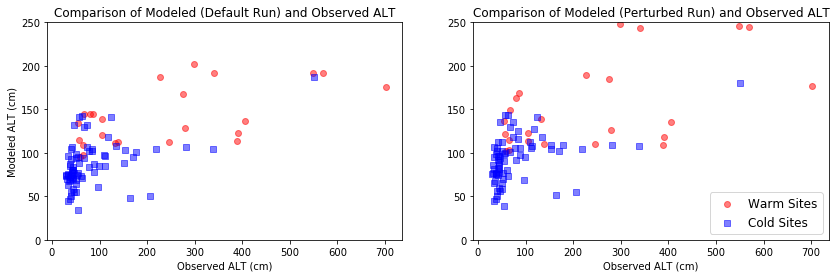

In [61]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))

t = -5

alt_default_values_cold = annual_max_alt.where((domain.mask == 1) & (annual_max_alt > 0) & (params.avg_T <= t), 
                                                  drop=True).values
alt_default_values_warm = annual_max_alt.where((domain.mask == 1) & (annual_max_alt > 0) & (params.avg_T > t), 
                                                  drop=True).values

alt_observed_values_cold = observed_alt.where((domain.mask == 1) & (annual_max_alt > 0) & (params.avg_T <= t), 
                                         drop=True).values
alt_observed_values_warm = observed_alt.where((domain.mask == 1) & (annual_max_alt > 0) & (params.avg_T > t), 
                                         drop=True).values

alpha = 0.5

ax[0].scatter(alt_observed_values_warm, alt_default_values_warm * 100, color='red', 
              marker='o', 
              alpha=alpha)
ax[0].scatter(alt_observed_values_cold, alt_default_values_cold * 100, color='blue', 
              marker='s', 
              alpha=alpha)

ax[0].set_xlabel('Observed ALT (cm)')
ax[0].set_ylabel('Modeled ALT (cm)')
ax[0].set_title('Comparison of Modeled (Default Run) and Observed ALT')

alt_perturbed_values_cold = annual_max_alt_pertrun.where((domain.mask == 1) & (annual_max_alt_pertrun > 0) & (params.avg_T <= t), 
                                                  drop=True).values
alt_perturbed_values_warm = annual_max_alt_pertrun.where((domain.mask == 1) & (annual_max_alt_pertrun > 0) & (params.avg_T > t), 
                                                  drop=True).values

alt_observed_values_cold = observed_alt.where((domain.mask == 1) & (annual_max_alt_pertrun > 0) & (params.avg_T <= t), 
                                         drop=True).values
alt_observed_values_warm = observed_alt.where((domain.mask == 1) & (annual_max_alt_pertrun > 0) & (params.avg_T > t), 
                                         drop=True).values

ax[1].scatter(alt_observed_values_warm, alt_perturbed_values_warm * 100, color='red', marker='o', 
              label='Warm Sites', 
              alpha=alpha)
ax[1].scatter(alt_observed_values_cold, alt_perturbed_values_cold * 100, color='blue', marker='s', 
              label='Cold Sites', 
              alpha=alpha)

ax[1].set_xlabel('Observed ALT (cm)')
ax[1].set_title('Comparison of Modeled (Perturbed Run) and Observed ALT')

ax[0].set_ylim([0, 250])
ax[1].set_ylim([0, 250])
ax[1].legend(loc='lower right', prop={'size': 12})

plotname = 'scatter_plot_modeled_defaultandperturbed_observed_alt.png'
savepath = plot_direc
if not os.path.exists(savepath):
    os.makedirs(savepath)
plt.savefig(os.path.join(savepath, plotname), format='png', dpi=dpi, bbox_inches='tight')

## compare ALT for Willowlake River site ## 

In [62]:
# extract august months 
willowlake_aug_soil_temp_pertrun = august_mean_soil_temp_pertrun[:, :, 43, 148].loc[dict(time=slice('1993', '2012'))]
willowlake_aug_soil_temp_defrun = august_mean_soil_temp[:, :, 43, 148].loc[dict(time=slice('1993', '2012'))]

# calculate alt using spline interpolation function used above 
willowlake_alt_def = willowlake_aug_soil_temp_defrun.groupby('time').apply(spline_interp)
willowlake_alt_pert = willowlake_aug_soil_temp_pertrun.groupby('time').apply(spline_interp)

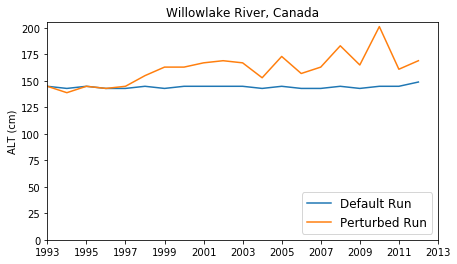

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

# Willowlake River, Canada: 62.6967, -123.065. (43, 148)
nj_ind = 43
ni_ind = 148

# 1993 - 2012
years_obs = np.arange(1993, 2013)
obs = [79, 83, 84, 90, 87, 89, 91, 82, 86, 88, 86, 80, 82, 89, 88, 89, 89, 90, 90.5, 91]
# obs: 79	83	84	90	87	89	91	82	86	88	86	80	82	89	88	-	-	90	-	91

ax.plot(years_obs, willowlake_alt_def*100, label='Default Run')
ax.plot(years_obs, willowlake_alt_pert*100, label='Perturbed Run')
# ax.plot(years_obs, obs, label='Observed')
ax.legend(loc='lower right', prop={'size': 12})
ax.set_ylabel('ALT (cm)')
ax.set_ylim([0, 205])
ax.set_xlim([1993, 2013])
# print(ax.get_xticks())
# plt.xticks(np.arange(1993, 2013, 1.0))
# ax.set_xticklabels(years_obs)
ax.xaxis.set_ticks(np.arange(1993, 2014, 2))
ax.set_title('Willowlake River, Canada')

plotname = 'willowlake_compare_alt.png'
savepath = plot_direc
if not os.path.exists(savepath):
    os.makedirs(savepath)
plt.savefig(os.path.join(savepath, plotname), format='png', dpi=dpi, bbox_inches='tight')

## get depths for cartoon of experiment ## 

In [64]:
# Willowlake River, Canada: 62.6967, -123.065. (43, 148)
nj_ind = 43
ni_ind = 148

params.depth[:, 43, 148] * 100

<xarray.DataArray 'depth' (nlayer: 3)>
array([ 30.    ,  50.    ,  23.2558])
Coordinates:
    yc       float64 62.77
    xc       float64 -123.4
Dimensions without coordinates: nlayer

In [65]:
30 + .33*50

46.5